In [1]:
import numpy as np
import pandas as pd
from math import ceil, floor
from glob import glob
from tqdm.auto import tqdm
import h5py
import os.path
from scipy import stats

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu

# Plot settings

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import gaussian, fftconvolve
from matplotlib import ticker as mticker
import pygbrowse
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap as cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors

plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
plt.matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

boxprops = {
    'boxprops':{'edgecolor':'k','linewidth':1},
    'medianprops':{'color':'k','linewidth':1},
    'whiskerprops':{'color':'k','linewidth':1},
    'capprops':{'color':'k','linewidth':1}
}

coldict = {'ESCs_d0':'#a8cbeb',
           'ES_d0':'#a8cbeb',
           'ES_d0_fromVitaminC':'#a8cbeb', 
           'VitaminC_d2':'#b4dbc6',
           'VitaminC_d3':'#73c09a', 
           'VitaminC_d4':'#168786', 
           'VitaminC_d5':'#146187', 
           'VitaminC_d6':'#04425b',
           'CAST_EiJ':'#3131dd',
           '129S1_SvImJ':'#b72323'
}

# Global variables

In [3]:
CHROMS = [str(i) for i in list(range(1,20)) + ["X"]]
CHROMSIZES = '/Users/prullens/metadata/mm10_chrom_sizes.tsv'
chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(sum).to_dict()

BINSIZE = 100000
SMOOTH_STDDEV = 150000

BLACKLIST = '/Users/prullens/metadata/mm10.blacklist.bed'
EXPECTED = '/Users/prullens/metadata/mm10_mappability_binsize_%i.hdf5' #%BINSIZE

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

W = gaussian(ceil(SMOOTH_STDDEV / BINSIZE * 6 / 2) * 2 + 1, SMOOTH_STDDEV / BINSIZE)
W /= W.sum()

DAMCASFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_CAST_snps.top_n_1.event_counts.PE_R1.binsize_100000.hdf5'
DAM129FMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_129S1_SvImJ_snps.top_n_1.event_counts.PE_R1.binsize_100000.hdf5'

CHICCASFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_CAST_snps.top_n_1.chic.PE_R1.AT_noTC.event_counts.binsize_100000.hdf5'
CHIC129FMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_129S1_SvImJ_snps.top_n_1.chic.PE_R1.AT_noTC.event_counts.binsize_100000.hdf5'

DAMFNFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.top_n_2.event_counts.binsize_%i.hdf5'
CHICFNFMT1 = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.top_n_1.chic.AT_noTC.event_counts.binsize_%i.hdf5'
CHICFNFMT2 = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.top_n_2.chic.AT_noTC.event_counts.binsize_%i.hdf5'

OUTDIR = '/Users/prullens/Documents/manuscripts/Kefalopoulou_2021/figure_XCI/PR20230411/'

# Data

_Metadata_

In [4]:
anno8164 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8164/KIN8164_anno.tsv', sep='\t')
anno8164.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in anno8164[['limsid','indexnr','barcodenr']].values]
anno8164['antibody'] = anno8164['antibody'].str[2:]
anno8164['cell_type'] = anno8164['cell_type'].str.replace('VitCdiff','VitaminC')

In [5]:
anno8403 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8403/KIN8403_anno.tsv', sep='\t')
anno8403 = anno8403[~anno8403['indexnr'].isin([31,32,33,34])].copy()
anno8403.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in anno8403[['limsid','indexnr','barcodenr']].values]

In [6]:
anno8433_xci = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8433_xci/KIN8433_anno_Xi.tsv', sep='\t')
anno8433_xci.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in anno8433_xci[['limsid','indexnr','barcodenr']].values]

In [7]:
anno8791 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8791_xci/KIN8791_anno_Xi.tsv', sep='\t')
anno8791.index = ['KIN8791_KIN8928_xci.index{:02d}.{:03d}'.format(i,bc) for i,bc in anno8791[['indexnr','barcodenr']].values]

idxs = [21,22,23,27,28,29,36,37] #only parse Dam-lb1/k9me3 & Dam-k27/lb1 data
anno8791 = pd.DataFrame(anno8791[anno8791['indexnr'].isin(idxs)])

anno8791['limsid'] = 'KIN8791_KIN8928_xci'

In [8]:
anno10644 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN10644/KIN10644_anno.tsv', sep='\t')
anno10644.index = ['KIN10644.index{:02d}.{:03d}'.format(i,bc) for i,bc in anno10644[['indexnr','barcodenr']].values]
anno10644 = anno10644[(anno10644['cell_type'] == 'ESCs_d0') | (anno10644['cell_type'].str.startswith('VitaminC'))].copy()
anno10644 = anno10644[(anno10644['construct'] == 'Dam-scFv-K27me3') & (anno10644['antibody'] == 'H2AK119Ub')].copy()
anno10644 = anno10644.loc[:,anno8791.columns].copy()

In [9]:
anno = pd.concat([anno8164,anno8403,anno8433_xci,anno8791,anno10644])

anno.shape

(13824, 13)

In [10]:
constructs = ['Dam-LmnB1','Dam-scFv-K27me3']
antibodies = ['K27me3','K9me3','LmnB1','H2AK119Ub']

anno = anno[~anno['cell_type'].str.contains('NPC')].copy()
anno = anno[anno['construct'].isin(constructs) & anno['antibody'].isin(antibodies)]

anno.shape

(8448, 13)

_Xi dynamic regions_

In [11]:
lb1_k27_idx = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8164/PR20230209.chrx_lb1_k27_changing_bins_100kb.tsv', header=None)[0].values

lb1_k27_idx.sum()

711

_pygBrowse_

In [12]:
genemodels = pygbrowse.datasources.Gff3Annotations('/Users/prullens/metadata/Mus_musculus.GRCm38.93.chr.gff3.bgzf', 
                                                   component_types=('CDS','three_prime_UTR', 'five_prime_UTR')
)
genemodel_plotter = pygbrowse.plots.GeneModelPlot(genemodels, 
                                                  color='k', 
                                                  chevron_width=0.04,
                                                  chevron_linewidth=.6,
                                                  chevron_spacing=.4, 
                                                  gene_name_fontsize=4
)

_DamID_

In [13]:
hdf5_list = [DAMCASFMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_dam_cas, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED %BINSIZE, 
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS
)
anno['dam_counts_cas'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_dam_cas)

  0%|          | 0/8447 [00:00<?, ?it/s]

7947

In [14]:
hdf5_list = [DAM129FMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_dam_129, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED %BINSIZE,
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS,
)
anno['dam_counts_129'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_dam_129)

  0%|          | 0/8447 [00:00<?, ?it/s]

8034

_ChIC_

In [15]:
hdf5_list = [CHICCASFMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_chic_cas, depths = scct.compute_oe(hdf5_list, 
                                      BINSIZE, 
                                      CHROMSIZES, 
                                      depth_thrs=200, 
                                      expected=EXPECTED %BINSIZE, 
                                      blacklist=BLACKLIST, 
                                      chroms=CHROMS,
)
anno['chic_counts_cas'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_chic_cas)

  0%|          | 0/8445 [00:00<?, ?it/s]

7115

In [17]:
hdf5_list = [CHIC129FMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_chic_129, depths = scct.compute_oe(hdf5_list, 
                                      BINSIZE, 
                                      CHROMSIZES, 
                                      depth_thrs=200, 
                                      expected=EXPECTED %BINSIZE, 
                                      blacklist=BLACKLIST, 
                                      chroms=CHROMS,
)
anno['chic_counts_129'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_chic_129)

  0%|          | 0/8445 [00:00<?, ?it/s]

7163

# Plotting

In [51]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]
anno_sub.shape

(7084, 17)

In [52]:
anno_sub.groupby(['construct','antibody','cell_type']).size().to_frame('Cells')

Cells
construct       antibody  cell_type                
Dam-LmnB1       K27me3    ES_d0_fromVitaminC    315
                          VitaminC_d2           338
                          VitaminC_d3           338
                          VitaminC_d4           344
                          VitaminC_d5           328
                          VitaminC_d6           329
                K9me3     ES_d0                  97
                          VitaminC_d2           104
                          VitaminC_d3           105
                          VitaminC_d4           102
                          VitaminC_d5           100
                          VitaminC_d6           109
                LmnB1     ES_d0                  89
                          VitaminC_d2            90
                          VitaminC_d3            79
                          VitaminC_d4            80
                          VitaminC_d5            79
                          VitaminC_d6            93
Dam-scFv-K27me3 H2AK119Ub ESCs_d0               230
                          VitaminC_d2           228
                          VitaminC_d3           233
                          VitaminC_d4           234
                          VitaminC_d5           240
                          VitaminC_d6           239
                K9me3     ES_d0                  86
                          VitaminC_d2           109
                          VitaminC_d3           108
                          VitaminC_d4           115
                          VitaminC_d5           116
                          VitaminC_d6           108
                LmnB1     ES_d0                 153
                          VitaminC_d2           148
                          VitaminC_d3          1157
                          VitaminC_d4           153
                          VitaminC_d5           159
                          VitaminC_d6           149

In [53]:
idx = (((anno_sub['construct'] == 'Dam-LmnB1') & (anno_sub['antibody'] == 'K27me3')) | 
       ((anno_sub['construct'] == 'Dam-LmnB1') & (anno_sub['antibody'] == 'K9me3')) | 
       ((anno_sub['construct'] == 'Dam-scFv-K27me3') & (anno_sub['antibody'] == 'LmnB1')) | 
       ((anno_sub['construct'] == 'Dam-scFv-K27me3') & (anno_sub['antibody'] == 'K9me3'))
)
idx = idx & anno_sub['cell_type'].str.contains('VitaminC')

idx.sum()

4834

/var/folders/d3/ds8510h555lcqcfl049qyr_40000gn/T/ipykernel_15531/1267091725.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.unique(X), rotation=45, ha='right')


Text(0, 0.5, 'Unique counts')

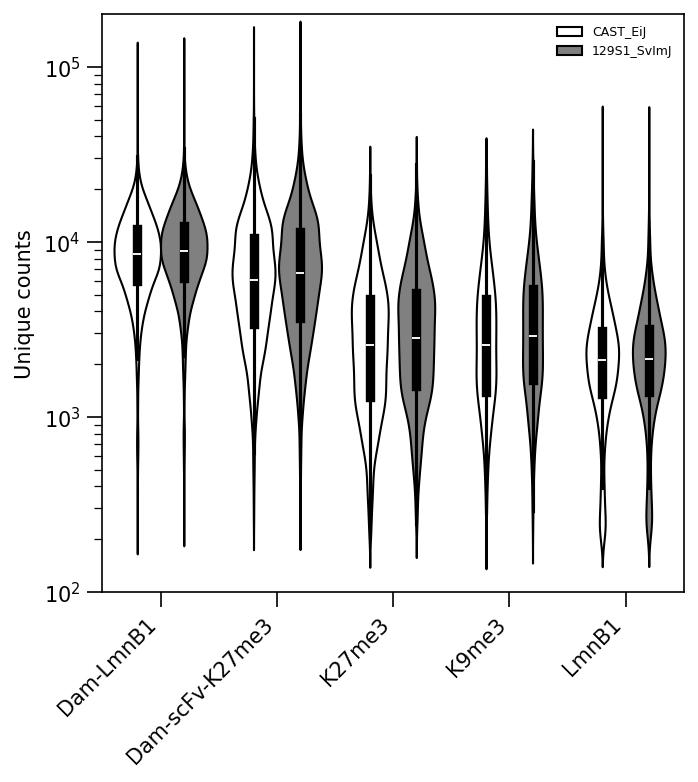

In [54]:
X = np.r_[np.tile(anno_sub.loc[idx,'construct'], 2), np.tile(anno_sub.loc[idx,'antibody'], 2)]
y = np.log10(np.hstack(anno_sub.loc[idx,['dam_counts_cas',
                                         'dam_counts_129',
                                         'chic_counts_cas',
                                         'chic_counts_129']].values.T)
)
hue = np.repeat(['CAST_EiJ','129S1_SvImJ','CAST_EiJ','129S1_SvImJ'], idx.sum())

f, ax = plt.subplots(figsize=(5,5))

sns.violinplot(x=X, 
               y=y, 
               hue=hue, 
               palette=['white','gray'],
               density_norm='count', 
               edgecolor='k',
               linewidth=1, 
)

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = ax.get_ylim()
tick_range = np.arange(np.floor(ymin), ymax)
ax.yaxis.set_ticks(tick_range)
ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.tick_params(length=4, which='minor')

ax.set_ylim(top=5.3)
ax.legend(prop={'size':6}, frameon=False)

ax.set_ylim(2)

ax.set_xticklabels(np.unique(X), rotation=45, ha='right')
ax.set_ylabel('Unique counts')

____

# Dam-Lmnb1 & K27me3 - VitaminC

In [55]:
construct = 'Dam-LmnB1'
antibody = 'K27me3'
cell_type = 'VitaminC'

In [56]:
anno_sub = pd.DataFrame(anno_sub[(anno_sub['construct'] == construct) &
                                 (anno_sub['antibody'] == antibody) & 
                                 (anno_sub['cell_type'].str.contains(cell_type))]
)

anno_sub.shape

(1992, 17)

In [57]:
umap_pt = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/PR20230331.vitc_k27_umap_pseudotime.csv', index_col=0)

In [58]:
umap_pt = umap_pt[umap_pt.index.isin(anno_sub.index)]

umap_pt.shape

(1656, 3)

In [59]:
anno_sub[['UMAP_1','UMAP_2','pseudotime']] = np.nan
anno_sub.loc[umap_pt.index,['UMAP_1','UMAP_2','pseudotime']] = umap_pt.values

In [60]:
anno_sub = pd.DataFrame(anno_sub[~anno_sub['UMAP_1'].isna()])

anno_sub.shape

(1656, 20)

In [61]:
anno_sub = anno_sub.sort_values('pseudotime')

In [62]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct antibody cell_type                
Dam-LmnB1 K27me3   ES_d0_fromVitaminC    296
                   VitaminC_d2           277
                   VitaminC_d3           267
                   VitaminC_d4           258
                   VitaminC_d5           261
                   VitaminC_d6           297

In [63]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-LmnB1', 'K27me3', 'ES_d0_fromVitaminC'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d2'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d3'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d4'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d5'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d6')],
 6)

____

Text(0, 0.5, 'UMAP2')

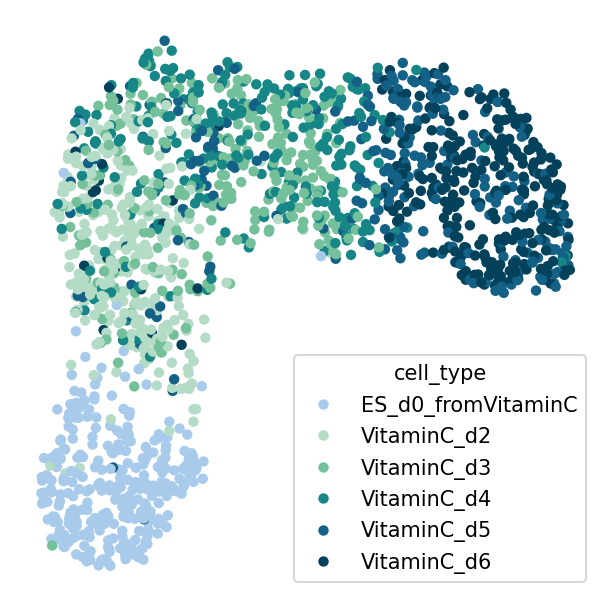

In [65]:
f, ax = plt.subplots(figsize=(5,5))

sns.scatterplot(x=anno_sub['UMAP_1'] *-1, 
                y=anno_sub['UMAP_2'], 
                hue=anno_sub['cell_type'], 
                hue_order=np.unique(anno_sub['cell_type']), 
                palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])], 
                s=25, 
                lw=0, 
)

plt.axis('off')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

_____

____

____

In [68]:
chrom = 'X'

In [69]:
incl_idx = oe_dam_cas[list(oe_dam_cas)[0]][chrom] > .101

incl_idx.size, incl_idx.sum()

(1711, 1511)

In [70]:
thrs = 1.5

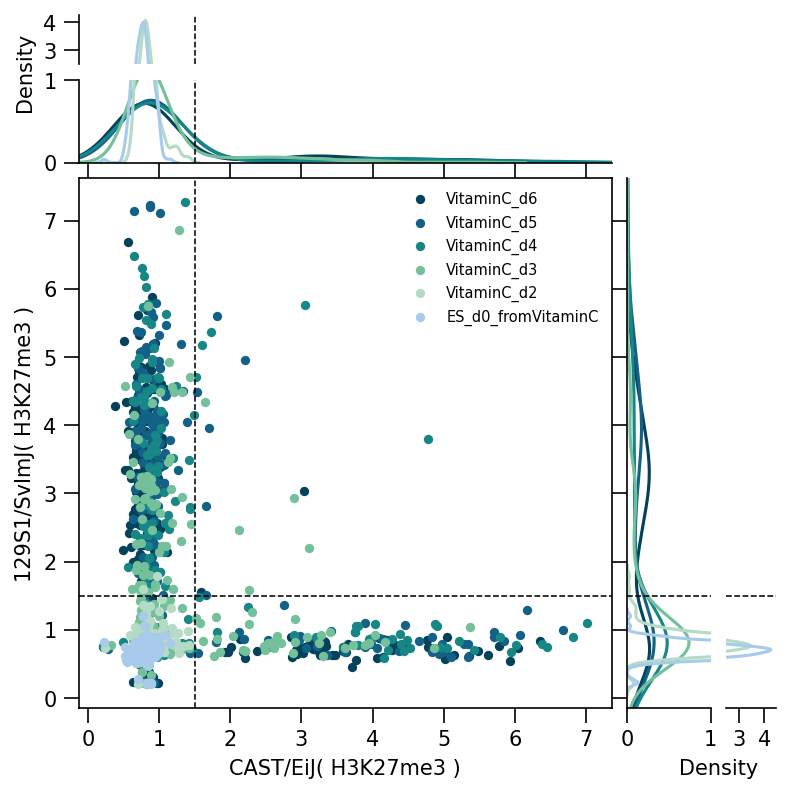

In [74]:
f, ax = plt.subplots(3, 3, figsize=(6,6), gridspec_kw={'height_ratios':[.075,.125,.8],
                                                       'width_ratios':[.8,.125,.075],
                                                       'hspace':.07,
                                                       'wspace':.07},
)

for i,g in enumerate(list(bc_dict)[::-1]):
    X = np.mean([fftconvolve(oe_chic_cas[bc][chrom], W, mode='same')[incl_idx] for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_chic_129[bc][chrom], W, mode='same')[incl_idx] for bc in bc_dict[g]], axis=1)
    
    sns.scatterplot(x=X, 
                    y=y, 
                    color=coldict[g[-1]],
                    s=20,
                    label=g[-1], 
                    lw=0,
                    ax=ax[2,0]
    )
    
    sns.kdeplot(x=X, 
                color=coldict[g[-1]], 
                ax=ax[0,0], 
                common_norm=False
    )
    sns.kdeplot(x=X, 
                color=coldict[g[-1]], 
                ax=ax[1,0], 
                common_norm=False
    )
    
    sns.kdeplot(y=y, 
                color=coldict[g[-1]], 
                common_norm=False,
                ax=ax[2,1]
    )
    sns.kdeplot(y=y, 
                color=coldict[g[-1]], 
                common_norm=False,
                ax=ax[2,2]
    )
    
ax[0,1].remove()
ax[0,2].remove()
ax[1,1].remove()
ax[1,2].remove()
ax[0,0].spines[['bottom','top','right']].set_visible(False)
ax[1,0].spines[['top','right']].set_visible(False)
ax[2,1].spines[['right','top']].set_visible(False)
ax[2,2].spines[['left','top','right']].set_visible(False)
ax[0,0].set_xticks([])
ax[2,2].set_yticks([])

ax[0,0].set_xlim(ax[2,0].get_xlim())
ax[1,0].set_xlim(ax[2,0].get_xlim())
ax[2,1].set_ylim(ax[2,0].get_ylim())
ax[2,2].set_ylim(ax[2,0].get_ylim())
ax[1,0].set_xticklabels([])
ax[2,1].set_yticklabels([])

ax[2,0].legend(prop={'size':7}, frameon=False)

ax[0,0].set_ylim(2.5)
ax[1,0].set_ylim(0,1)
ax[2,1].set_xlim(0,1)
ax[2,2].set_xlim(2.5)

ax[0,0].set_ylabel('')
ax[1,0].set_ylabel('Density', y=1.1)
ax[2,1].set_xlabel('Density', x=1.1)
ax[2,2].set_xlabel('')

ax[2,0].set_xlabel('CAST/EiJ( H3K27me3 )')
ax[2,0].set_ylabel('129S1/SvImJ( H3K27me3 )')

for i in range(ax.shape[0]):
    ax[i,0].axvline(thrs, color='k', lw=.75, ls='--')
    ax[2,i].axhline(thrs, color='k', lw=.75, ls='--')

Text(0, 0.5, '129S1_SvImJ(Dam-Lmnb1)')

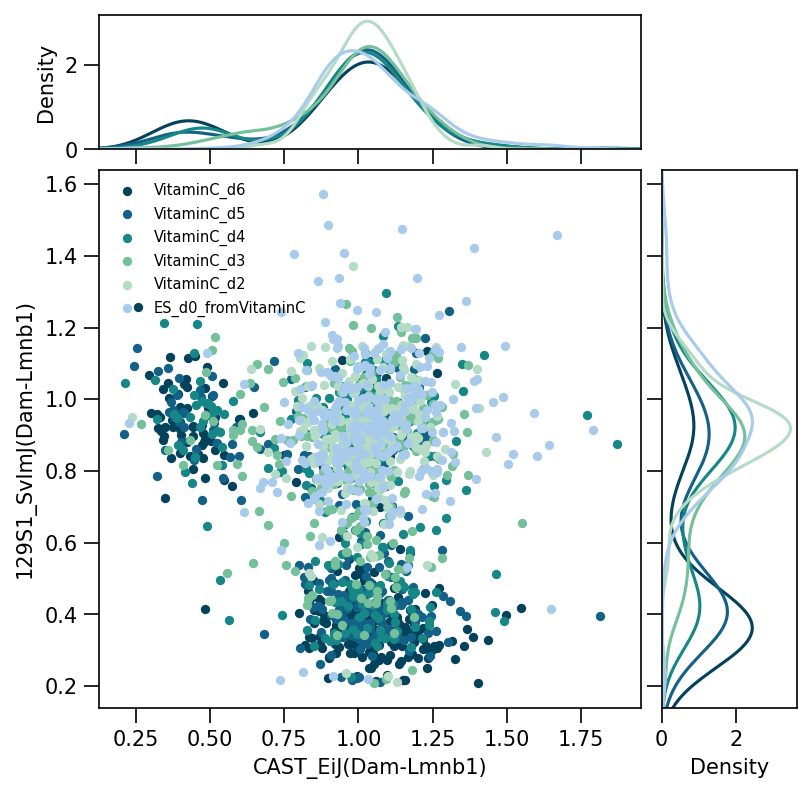

In [75]:
f, ax = plt.subplots(2, 2, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.2],
                                                       'hspace':.06,
                                                       'wspace':.06},
)

for i,g in enumerate(list(bc_dict)[::-1]):
    X = np.mean([fftconvolve(oe_dam_cas[bc][chrom], W, mode='same')[lb1_k27_idx] for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_dam_129[bc][chrom], W, mode='same')[lb1_k27_idx] for bc in bc_dict[g]], axis=1)
    
    sns.scatterplot(x=X, 
                    y=y, 
                    color=coldict[g[-1]],
                    s=20,
                    linewidth=0, 
                    label=g[-1], 
                    ax=ax[1,0]
    )
    
    sns.kdeplot(x=X, 
                color=coldict[g[-1]], 
                ax=ax[0,0]
    )
    
    sns.kdeplot(y=y, 
                color=coldict[g[-1]], 
                common_norm=False,
                ax=ax[1,1]
    )
    
ax[0,1].remove()
ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])

ax[1,0].legend(prop={'size':7}, frameon=False)

ax[1,0].set_xlabel('CAST_EiJ(Dam-Lmnb1)')
ax[1,0].set_ylabel('129S1_SvImJ(Dam-Lmnb1)')

_____

In [76]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [77]:
bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_chic_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_chic_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((1656,), array([994,  20, 169, 473]))

In [78]:
#make sure `bcs` has same order as `anno_sub.index`
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

______

/var/folders/d3/ds8510h555lcqcfl049qyr_40000gn/T/ipykernel_15531/1470943018.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(states.values(), rotation=45, ha='right')


(0.0, 300.0)

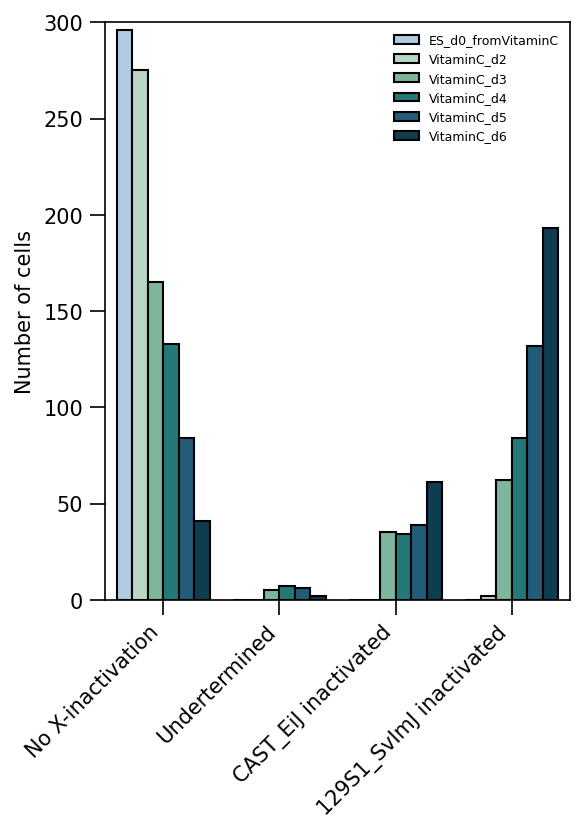

In [79]:
labels = np.repeat([g[-1] for g in bc_dict], 4).reshape(len(bc_dict),4)

X = np.zeros((len(bc_dict),4))
for i,g in enumerate(bc_dict):
    idx = np.isin(bcs, bc_dict[g])
    X[i] = state[idx].sum(0)
    
f, ax = plt.subplots(figsize=(4,5))

sns.barplot(x=np.hstack(np.tile(list(states.values()), 6)), 
            y=np.hstack(X), 
            hue=np.hstack(labels), 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
            edgecolor='k',
)

ax.set_ylabel('Number of cells')
ax.set_xticklabels(states.values(), rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1,1), prop={'size':6}, frameon=False)
ax.set_ylim(0,300)

____

In [80]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], W, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], W, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], W, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], W, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((1656, 2, 1711), (1656, 2, 1711))

___

In [89]:
lb1 = (dam3d[state[:,3],1] > 1).mean(0)
k27 = (chic3d[state[:,3],1] > 1).mean(0)

lb1_thrs = .15
k27_thrs = .75
_lb1_anchors_idx = (k27 < k27_thrs) & (lb1 > lb1_thrs)

_lb1_anchors_idx.sum(), _lb1_anchors_idx.size

(495, 1711)

Text(0.5, 0, 'Chromosome X (Mb)')

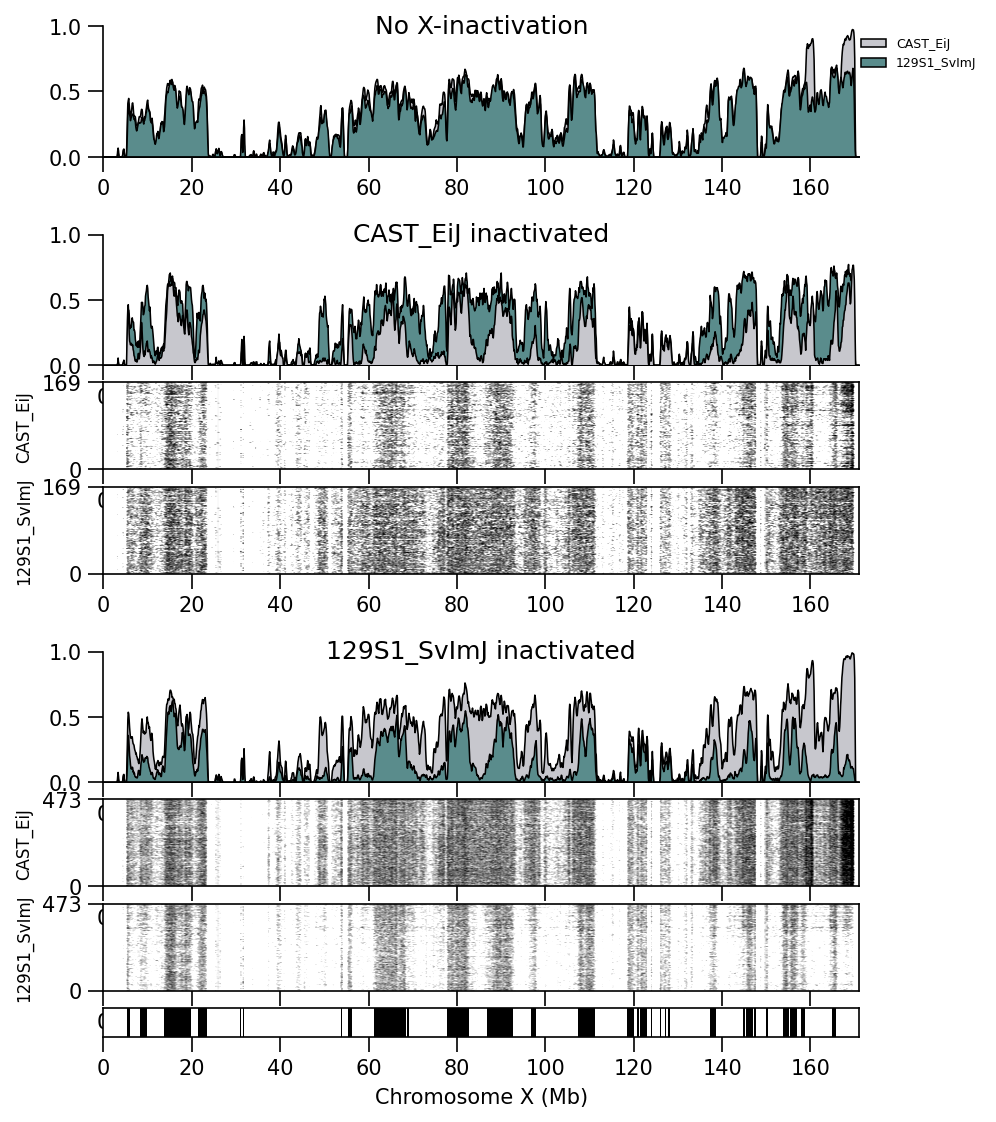

In [102]:
f, ax = plt.subplots(nrows=10, 
                     ncols=1, 
                     figsize=(6.5,1.25*7), 
                     gridspec_kw={'hspace':.2,
                                  'height_ratios':[.9,.3,.9,.6,.6,.3,.9,.6,.6,.2]
                                 }
)


for i0,(i,s) in enumerate(zip((0,2,6),(0,2,3))):
    ax[i].fill_between(xaxis, 
                       (dam3d[state[:,s],0] > 1).mean(0), 
                       color=matplotlib.colors.to_rgb('#C7C7CD') + (1,), 
                       lw=.75,
                       zorder=[0,10,0][i0],
                       edgecolor='k', 
                       label='CAST_EiJ'
    )
    ax[i].fill_between(xaxis, 
                       (dam3d[state[:,s],1] > 1).mean(0), 
                       color=matplotlib.colors.to_rgb('#5A8C8C') + (1,),
                       lw=.75,
                       edgecolor='k',
                       label='129S1_SvImJ'
    )
    
    ax[i].set_title(states[s], y=.85)
    ax[i].set_ylim(0,1)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].margins(x=0)

for i,s in zip((3,7),(2,3)):
    ax[i].imshow(np.log2(dam3d[state[:,s],0]), 
                 aspect='auto',
                 cmap='binary', 
                 vmin=-1.5, 
                 vmax=1.5, 
                 extent=np.hstack([xaxis[[0,-1]], 0, state[:,s].sum()])
    )
    ax[i+1].imshow(np.log2(dam3d[state[:,s],1]), 
                   aspect='auto',
                   cmap='binary', 
                   vmin=-1.5, 
                   vmax=1.5, 
                   extent=np.hstack([xaxis[[0,-1]], 0, state[:,s].sum()])
    )
    ax[i].set_ylabel('CAST_EiJ', fontsize=8)
    ax[i+1].set_ylabel('129S1_SvImJ', fontsize=8)
    
    ax[i].set_yticks([0,state[:,s].sum()])
    ax[i+1].set_yticks([0,state[:,s].sum()])
    
ax[-1].pcolorfast(xaxis, [0,1], np.atleast_2d(_lb1_anchors_idx), cmap='binary')
ax[-1].set_yticks([])
    
ax[1].remove()
ax[5].remove()

ax[0].legend(bbox_to_anchor=(1.17,1), prop={'size':6}, frameon=False)
ax[-1].set_xlabel('Chromosome %s (Mb)' %chrom)

____

Text(0.5, 0, 'Chromosome X (Mb)')

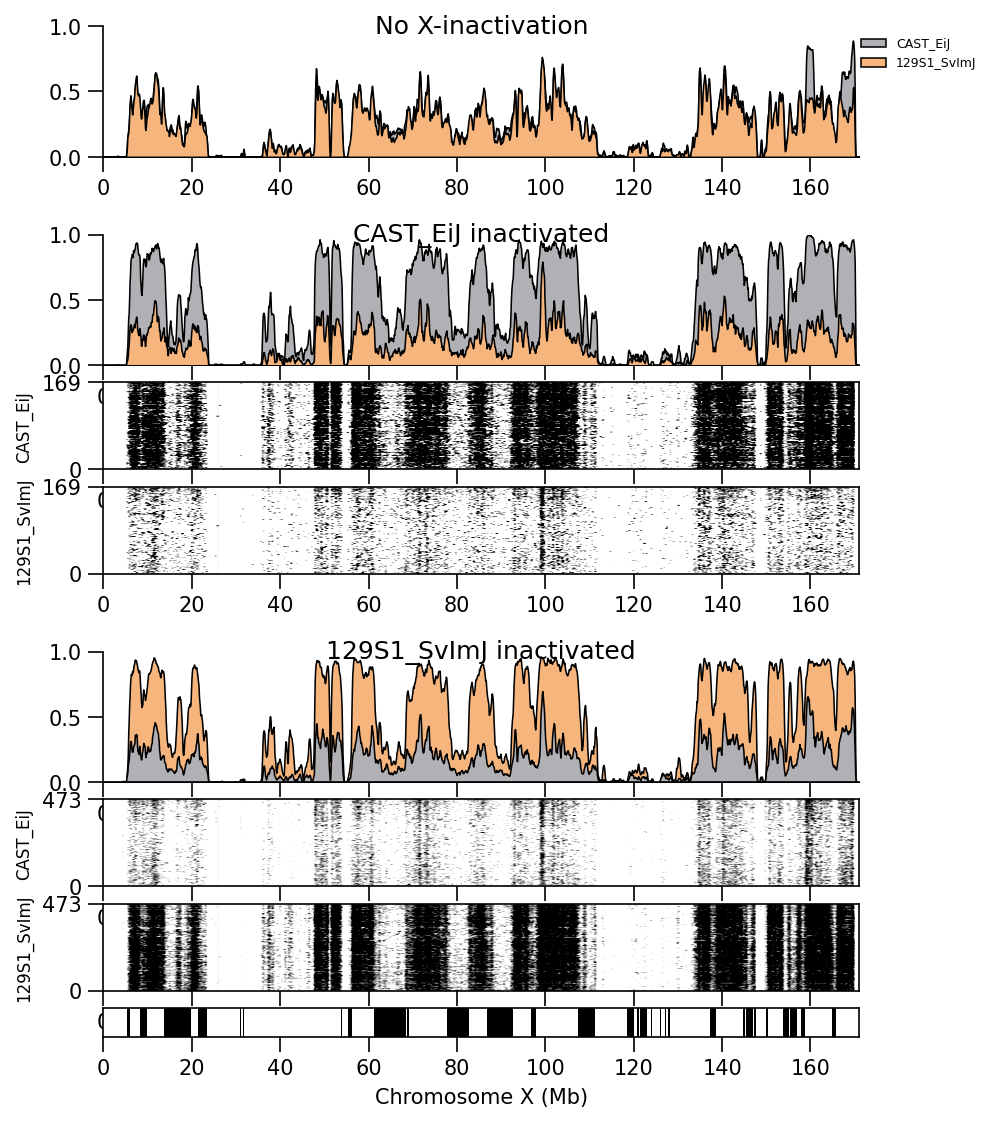

In [107]:
f, ax = plt.subplots(nrows=10, 
                     ncols=1, 
                     figsize=(6.5,1.25*7),
                     gridspec_kw={'hspace':.2,
                                  'height_ratios':[.9,.3,.9,.6,.6,.3,.9,.6,.6,.2]
                                 }
)


for i0,(i,s) in enumerate(zip((0,2,6),(0,2,3))):
    ax[i].fill_between(xaxis, 
                       (chic3d[state[:,s],0] > 1).mean(0), 
                       color=matplotlib.colors.to_rgb('#B1B1B5') + (1,), 
                       lw=.75,
                       edgecolor='k', 
                       label='CAST_EiJ'
    )
    ax[i].fill_between(xaxis, 
                       (chic3d[state[:,s],1] > 1).mean(0), 
                       color=matplotlib.colors.to_rgb('#F5B57D') + (1,),
                       lw=.75,
                       zorder=[10,10,0][i0],
                       edgecolor='k',
                       label='129S1_SvImJ'
    )
    
    ax[i].set_title(states[s], y=.85)
    ax[i].set_ylim(0,1)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].margins(x=0)

for i,s in zip((3,7),(2,3)):
    ax[i].imshow(np.log2(chic3d[state[:,s],0]), 
                 aspect='auto',
                 cmap='binary', 
                 vmin=-1.5, 
                 vmax=1.5, 
                 extent=np.hstack([xaxis[[0,-1]], 0, state[:,s].sum()])
    )
    ax[i+1].imshow(np.log2(chic3d[state[:,s],1]), 
                   aspect='auto',
                   cmap='binary', 
                   vmin=-1.5, 
                   vmax=1.5, 
                   extent=np.hstack([xaxis[[0,-1]], 0, state[:,s].sum()])
    )
    ax[i].set_ylabel('CAST_EiJ', fontsize=8)
    ax[i+1].set_ylabel('129S1_SvImJ', fontsize=8)
    
    ax[i].set_yticks([0,state[:,s].sum()])
    ax[i+1].set_yticks([0,state[:,s].sum()])
    
ax[-1].pcolorfast(xaxis, [0,1], np.atleast_2d(_lb1_anchors_idx), cmap='binary')
ax[-1].set_yticks([])
    
ax[1].remove()
ax[5].remove()

ax[0].legend(bbox_to_anchor=(1.17,1), prop={'size':6}, frameon=False)
ax[-1].set_xlabel('Chromosome %s (Mb)' %chrom)

_____

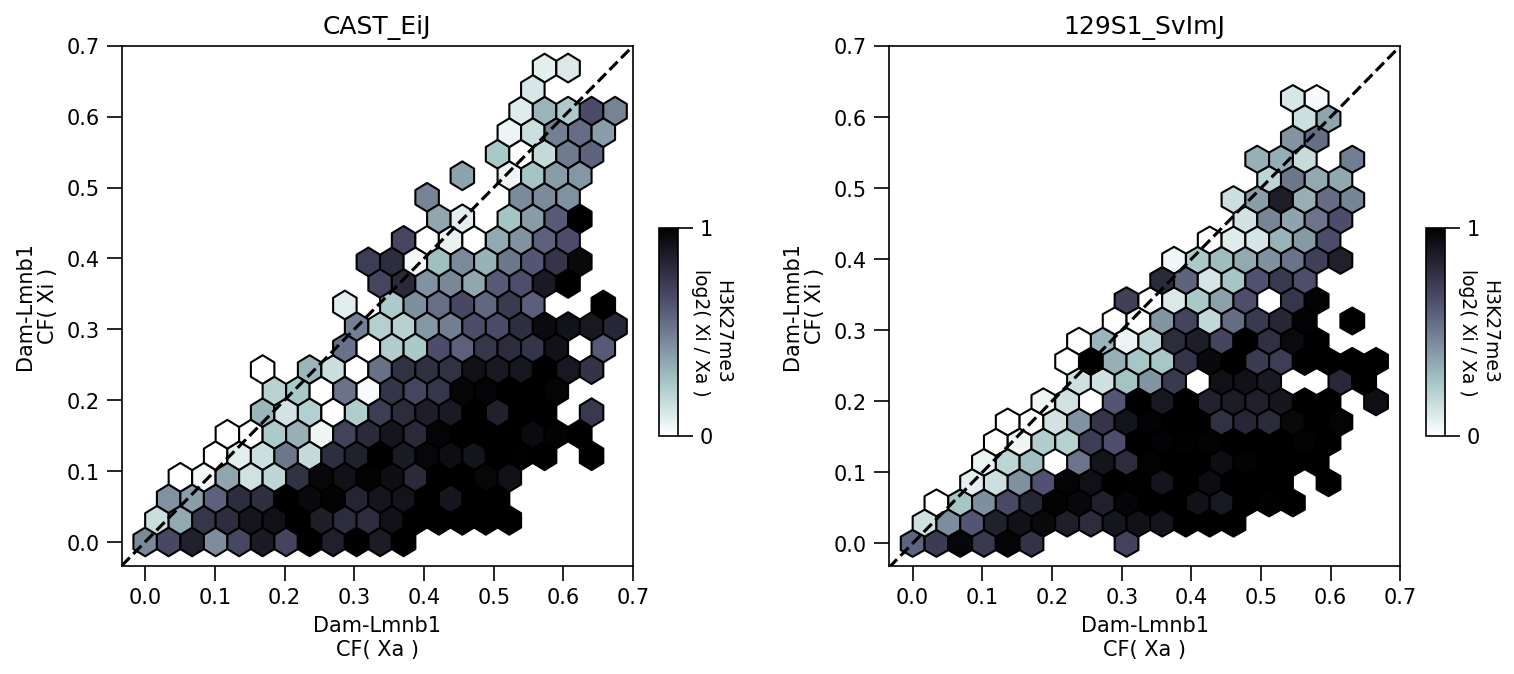

In [108]:
f, ax = plt.subplots(1, 2, figsize=(5.5*2,4.5), gridspec_kw={'wspace':.5})

for i,s in enumerate((2,3)):
    X = (dam3d[state[:,0],i] > 1).mean(0)[incl_idx][:-115] #exclude duplicated bins
    y = (dam3d[state[:,s],i] > 1).mean(0)[incl_idx][:-115]

    l2fc = np.log2(((chic3d[state[:,s],i] > 1).mean(0) + .1) / ((chic3d[state[:,0],i] > 1).mean(0) + .1))[incl_idx][:-115]


    vmin, vmax = 0, 1
    hb = ax[i].hexbin(x=X,  
                      y=y, 
                      C=l2fc,
                      gridsize=20, 
                      cmap='bone_r', 
                      vmin=vmin, 
                      vmax=vmax, 
                      mincnt=.1, 
                      edgecolors='k'
    )

    
    ax[i].set_ylim(top=.7)
    ax[i].set_xlim(right=.7)
    ax[i].plot(ax[i].get_xlim(),ax[i].get_xlim(), lw=1.5, color='k', ls='--')

    axins = inset_axes(ax[i],
       width="2.5%",  # width = 5% of parent_bbox width
       height="40%",  # height : 50%
       loc='lower left',
       bbox_to_anchor=(1.05, .25, 1.5, 1),
       bbox_transform=ax[i].transAxes,
       borderpad=0,
       )
    cbar = f.colorbar(hb, ax=ax[i], cax=axins, pad=.06, ticks=[vmin,vmax])
    cbar.ax.set_ylabel('H3K27me3\nlog2( Xi / Xa )', labelpad=9, rotation=270, fontsize=9)

    ax[i].set_xlabel('Dam-Lmnb1\nCF( Xa )')
    ax[i].set_ylabel('Dam-Lmnb1\nCF( Xi )')
    ax[i].set_title(['CAST_EiJ','129S1_SvImJ'][i])

______

Text(0.5, 0, 'Chromosome X (Mb)')

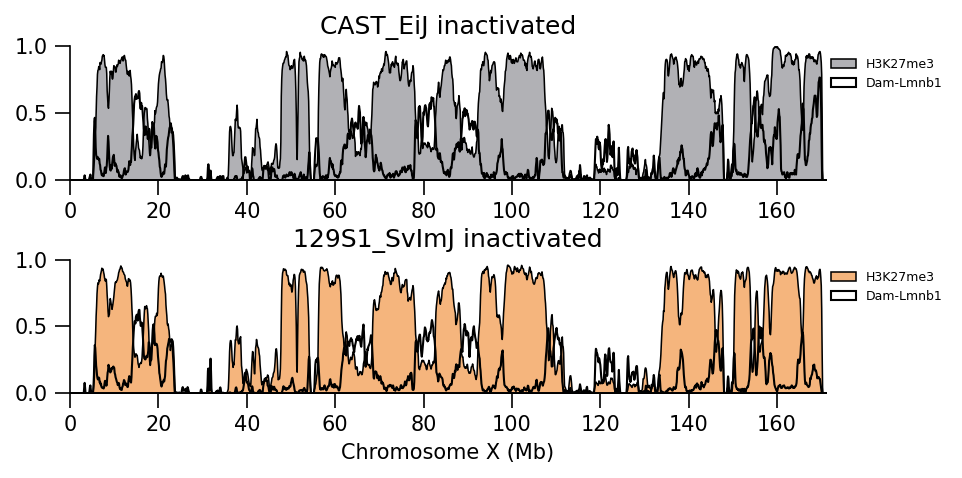

In [118]:
xaxis = np.arange(0,incl_idx.size*BINSIZE,BINSIZE) / 1e6

nrows = 2
f, ax = plt.subplots(nrows, 1, figsize=(6.5,1.5*nrows), gridspec_kw={'hspace':.6})

ax[0].fill_between(xaxis, 
                   (chic3d[state[:,2],0] > 1).mean(0), 
                   color='#B1B1B5', 
                   lw=.75,
                   edgecolor='k',
                   label='H3K27me3'
)
ax[0].fill_between(xaxis, 
                   (dam3d[state[:,2],0] > 1).mean(0),
                   color=matplotlib.colors.to_rgb('white') + (0,),
                   lw=1,
                   edgecolor='k',
                   label='Dam-Lmnb1'
)
ax[1].fill_between(xaxis, 
                   (chic3d[state[:,3],1] > 1).mean(0), 
                   color='#F5B57D', 
                   lw=.75,
                   edgecolor='k',
                   label='H3K27me3'
)
ax[1].fill_between(xaxis, 
                   (dam3d[state[:,3],1] > 1).mean(0), 
                   color=matplotlib.colors.to_rgb('white') + (0,),
                   lw=1,
                   edgecolor='k',
                   label='Dam-Lmnb1'
)
    
for i,s in enumerate((2,3)):
    ax[i].set_title(states[s])
    ax[i].set_ylim(0,1)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_yticks([0,.5,1])
    ax[i].legend(bbox_to_anchor=(1.17,1), prop={'size':6}, frameon=False)
    ax[i].margins(x=0)
    
ax[-1].set_xlabel('Chromosome %s (Mb)' %chrom)

____

# Dam-K27me3 & K9me3 - VitaminC

In [119]:
construct = 'Dam-scFv-K27me3'
antibody = 'K9me3'
cell_type = 'VitaminC'

In [120]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]

anno_sub.shape

(7084, 17)

In [121]:
anno_sub = anno_sub[(anno_sub['construct'] == construct) &
                    (anno_sub['antibody'] == antibody) & 
                    (anno_sub['cell_type'].str.contains(cell_type) | anno_sub['cell_type'].str.contains('ES'))]

anno_sub.shape

(642, 17)

In [145]:
umap_pt = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8403/PR20230223.vitc_damk27-k9_damk27-k27_pseudotime.csv', index_col=0)

In [146]:
umap_pt = umap_pt[umap_pt.index.isin(anno_sub.index)]

umap_pt.shape

(497, 3)

In [147]:
anno_sub[['UMAP_1','UMAP_2','pseudotime']] = np.nan
anno_sub.loc[umap_pt.index,['UMAP_1','UMAP_2','pseudotime']] = umap_pt.values

In [148]:
anno_sub = pd.DataFrame(anno_sub[~anno_sub['UMAP_1'].isna()])

anno_sub.shape

(497, 20)

In [149]:
anno_sub = anno_sub.sort_values('pseudotime')

In [150]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct       antibody cell_type         
Dam-scFv-K27me3 K9me3    ES_d0           74
                         VitaminC_d2     84
                         VitaminC_d3     83
                         VitaminC_d4     86
                         VitaminC_d5     91
                         VitaminC_d6     79

In [151]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-scFv-K27me3', 'K9me3', 'ES_d0'),
  ('Dam-scFv-K27me3', 'K9me3', 'VitaminC_d2'),
  ('Dam-scFv-K27me3', 'K9me3', 'VitaminC_d3'),
  ('Dam-scFv-K27me3', 'K9me3', 'VitaminC_d4'),
  ('Dam-scFv-K27me3', 'K9me3', 'VitaminC_d5'),
  ('Dam-scFv-K27me3', 'K9me3', 'VitaminC_d6')],
 6)

___

In [152]:
chrom = 'X'

In [153]:
incl_idx = oe_dam_cas[list(oe_dam_cas)[0]][chrom] > .101

incl_idx.size, incl_idx.sum()

(1711, 1511)

In [154]:
thrs = .875

In [155]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [156]:
bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_dam_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_dam_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((497,), array([272,  15,  84, 126]))

In [157]:
#make sure ``bcs`` has same order as ``anno_sub.index``
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

____

In [158]:
smooth_stddev = 350000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

In [159]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], w, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], w, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], w, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], w, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((497, 2, 1711), (497, 2, 1711))

In [160]:
dam2d = dam3d[:,:,lb1_k27_idx].mean(2)
chic2d = chic3d[:,:,lb1_k27_idx].mean(2)

dam2d.shape, chic2d.shape

((497, 2), (497, 2))

In [161]:
argsort2d = np.argsort(chic2d, axis=1)

argsort2d.shape

(497, 2)

___

Text(0.5, 0, 'Chromosome X (Mb)')

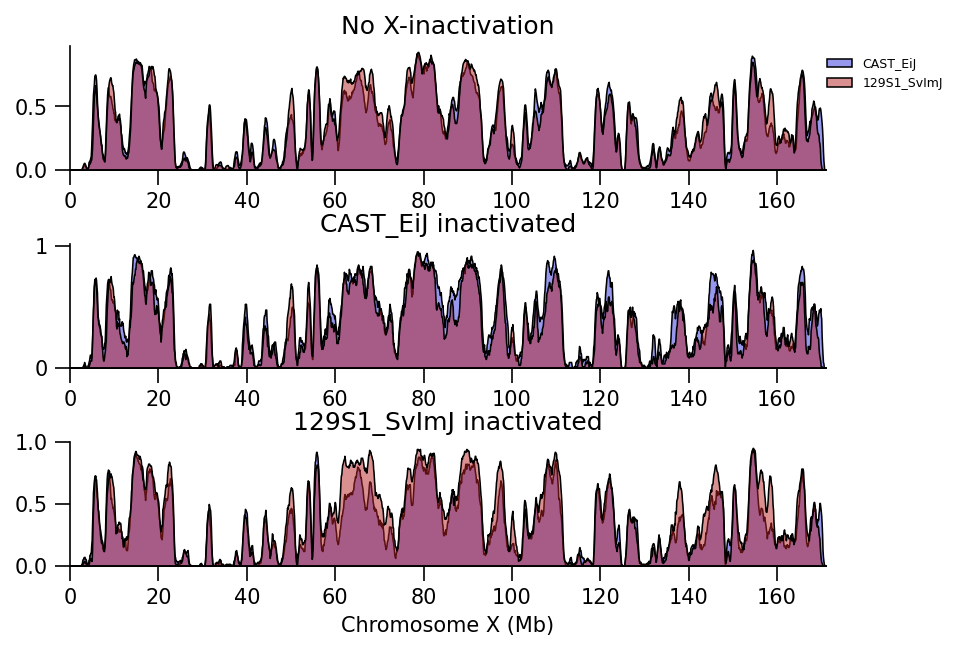

In [166]:
xaxis = np.arange(0,incl_idx.size*BINSIZE,BINSIZE) / 1e6

f, ax = plt.subplots(3, 1, figsize=(6.5,1.5*3), gridspec_kw={'hspace':.6})

for i,s in enumerate((0,2,3)):
    ax[i].fill_between(xaxis, 
                       (chic3d[state[:,s],0] > 1).mean(0), 
                       color=matplotlib.colors.to_rgb(coldict['CAST_EiJ']) + (.5,), 
                       lw=.75,
                       edgecolor='k', 
                       label='CAST_EiJ'
    )
    ax[i].fill_between(xaxis, 
                       (chic3d[state[:,s],1] > 1).mean(0), 
                       color=matplotlib.colors.to_rgb(coldict['129S1_SvImJ']) + (.5,),
                       lw=.75,
                       edgecolor='k',
                       label='129S1_SvImJ'
    )
    
    ax[i].set_title(states[s])
    ax[i].set_ylim(0)
    ax[i].margins(x=0)
    ax[i].spines[['right', 'top']].set_visible(False)
    
ax[0].legend(bbox_to_anchor=(1.17,1), prop={'size':6}, frameon=False)
ax[-1].set_xlabel('Chromosome %s (Mb)' %chrom)

___

In [163]:
#take from celli 350 to be sure to take cells with XCI
X = np.log2(np.take_along_axis(dam3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])[350:, _lb1_anchors_idx]
y = np.log2(np.take_along_axis(chic3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])[350:, _lb1_anchors_idx]

X.shape, y.shape

((147, 495), (147, 495))

Text(-1.95, -0.2, '$T_=-2.46$\n$p_=0.014$')

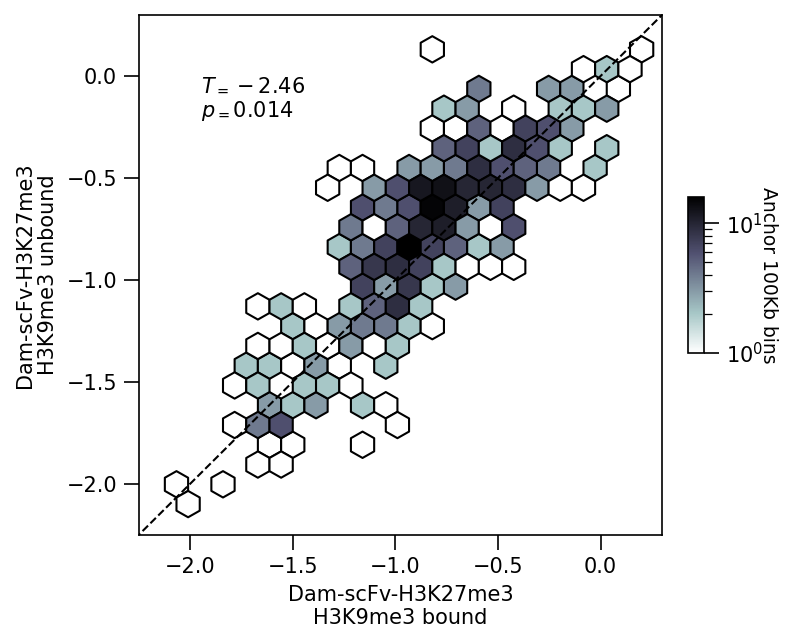

In [167]:
k9_bound = np.mean(X, where=y > 0, axis=0)
k9_unbound = np.mean(X, where=y < 0, axis=0)
X_line, y_line, ci = sccu.polynomial_regression(k9_bound, k9_unbound, 3)

f, ax = plt.subplots(figsize=(4.5,4.5))


hb = ax.hexbin(x=k9_bound, 
               y=k9_unbound, 
               bins='log', 
               gridsize=26, 
               mincnt=1,
               edgecolors='k', 
               cmap='bone_r'
)

ax.plot([-2.5,.5],[-2.5,.5], ls='--', color='k', lw=1)

ax.set_xlim(-2.25,.3)
ax.set_ylim(-2.25,.3)

axins = inset_axes(ax,
   width="2%",  # width = 5% of parent_bbox width
   height="30%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.05, .35, 1.5, 1),
   bbox_transform=ax.transAxes,
   borderpad=0,
   )
cbar = f.colorbar(hb, ax=ax, cax=axins, pad=.06)
cbar.ax.set_ylabel('Anchor 100Kb bins', labelpad=7, rotation=270, fontsize=9)

cbar.ax.tick_params(which='minor', length=4)

ax.set_xlabel('Dam-scFv-H3K27me3\nH3K9me3 bound')
ax.set_ylabel('Dam-scFv-H3K27me3\nH3K9me3 unbound')

tstat, p = stats.ttest_ind(k9_bound, k9_unbound)
ax.text(-1.95,-.2, '$T_={}$\n$p_={}$'.format(round(tstat,2),round(p,3)))

____

# Dam-Lmnb1 & H3K9me3

In [168]:
construct = 'Dam-LmnB1'
antibody = 'K9me3'
cell_type = 'VitaminC'

In [169]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]

anno_sub.shape

(7084, 17)

In [170]:
anno_sub = anno_sub[(anno_sub['construct'] == construct) &
                    (anno_sub['antibody'] == antibody) & 
                    (anno_sub['cell_type'].str.contains(cell_type) | (anno_sub['cell_type'] == 'ES_d0'))]

anno_sub.shape

(617, 17)

In [171]:
umap_pt = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8791_KIN8928_xci/PR20230917.vitc_damlb1-k9_pseudotime.csv', index_col=0)

In [172]:
umap_pt = umap_pt[umap_pt.index.isin(anno_sub.index)]

umap_pt.shape

(573, 3)

In [173]:
anno_sub[['UMAP_1','UMAP_2','pseudotime']] = np.nan
anno_sub.loc[umap_pt.index,['UMAP_1','UMAP_2','pseudotime']] = umap_pt.values

In [174]:
anno_sub = pd.DataFrame(anno_sub[~anno_sub['UMAP_1'].isna()])

anno_sub.shape

(573, 20)

In [175]:
anno_sub = anno_sub.sort_values('pseudotime')

In [176]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct antibody cell_type         
Dam-LmnB1 K9me3    ES_d0           84
                   VitaminC_d2     99
                   VitaminC_d3    102
                   VitaminC_d4     92
                   VitaminC_d5     91
                   VitaminC_d6    105

In [177]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-LmnB1', 'K9me3', 'ES_d0'),
  ('Dam-LmnB1', 'K9me3', 'VitaminC_d2'),
  ('Dam-LmnB1', 'K9me3', 'VitaminC_d3'),
  ('Dam-LmnB1', 'K9me3', 'VitaminC_d4'),
  ('Dam-LmnB1', 'K9me3', 'VitaminC_d5'),
  ('Dam-LmnB1', 'K9me3', 'VitaminC_d6')],
 6)

____

In [178]:
thrs = .7 #on Dam-Lmnb1 because no K27me3 measured in this dataset

In [179]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [180]:
bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_dam_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_dam_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X > thrs) & (y > thrs)
    idx_un = (X < thrs) & (y < thrs)
    idx_cas = (X < thrs) & (y > thrs)
    idx_129 = (y < thrs) & (X > thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((573,), array([353,   3,  52, 165]))

In [181]:
#make sure ``bcs`` has same order as ``anno_sub.index``
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

____

In [185]:
smooth_stddev = 350000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

In [186]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], w, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], w, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], w, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], w, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((573, 2, 1711), (573, 2, 1711))

In [187]:
dam2d = dam3d[:,:,lb1_k27_idx].mean(2)
chic2d = chic3d[:,:,lb1_k27_idx].mean(2)

dam2d.shape, chic2d.shape

((573, 2), (573, 2))

In [188]:
argsort2d = np.argsort(dam2d, axis=1)[:,::-1]

argsort2d.shape

(573, 2)

In [191]:
#take from celli 350 to be sure to take cells with XCI
X = np.log2(np.take_along_axis(dam3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])[350:, _lb1_anchors_idx]
y = np.log2(np.take_along_axis(chic3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])[350:, _lb1_anchors_idx]

X.shape, y.shape

((223, 495), (223, 495))

Text(-1.4, -0.1, '$T_=3.24$\n$p_=0.001$')

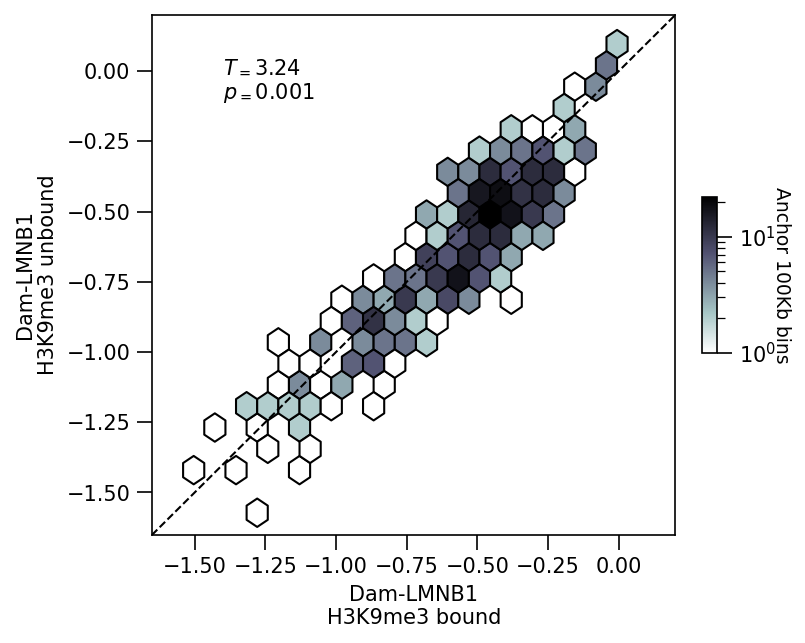

In [193]:
k9_bound = np.mean(X, where=y > 0, axis=0)
k9_unbound = np.mean(X, where=y < 0, axis=0)
X_line, y_line, ci = sccu.polynomial_regression(k9_bound, k9_unbound, 3)

f, ax = plt.subplots(figsize=(4.5,4.5))


hb = ax.hexbin(x=k9_bound, 
               y=k9_unbound, 
               bins='log', 
               gridsize=26, 
               mincnt=1,
               edgecolors='k', 
               cmap='bone_r'
)

ax.plot([-2.5,.5],[-2.5,.5], ls='--', color='k', lw=1)

ax.set_xlim(-1.65,.2)
ax.set_ylim(-1.65,.2)

axins = inset_axes(ax,
   width="2%",  # width = 5% of parent_bbox width
   height="30%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.05, .35, 1.5, 1),
   bbox_transform=ax.transAxes,
   borderpad=0,
   )
cbar = f.colorbar(hb, ax=ax, cax=axins, pad=.06)
cbar.ax.set_ylabel('Anchor 100Kb bins', labelpad=7, rotation=270, fontsize=9)

cbar.ax.tick_params(which='minor', length=4)

#ax.set_title('Dam-LmnB1')
ax.set_xlabel('Dam-LMNB1\nH3K9me3 bound')
ax.set_ylabel('Dam-LMNB1\nH3K9me3 unbound')

tstat, p = stats.ttest_ind(k9_bound, k9_unbound)
ax.text(-1.4,-.1, '$T_={}$\n$p_={}$'.format(round(tstat,2),round(p,3)))

#plt.savefig(OUTDIR + 'damlb1_k9un_bound_hexbin.pdf', bbox_inches='tight')

____

# Dam-K27me3 & Lmnb1

In [194]:
construct = 'Dam-scFv-K27me3'
antibody = 'LmnB1'
cell_type = 'VitaminC'

In [195]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]

anno_sub.shape

(7084, 17)

In [196]:
anno_sub = anno_sub[(anno_sub['construct'] == construct) &
                    (anno_sub['antibody'] == antibody) & 
                    (anno_sub['cell_type'].str.contains(cell_type) | anno_sub['cell_type'].str.contains('ES'))]

anno_sub.shape

(1919, 17)

In [197]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct       antibody cell_type         
Dam-scFv-K27me3 LmnB1    ES_d0          153
                         VitaminC_d2    148
                         VitaminC_d3   1157
                         VitaminC_d4    153
                         VitaminC_d5    159
                         VitaminC_d6    149

In [200]:
np.random.seed(4)

n = 159
_bcs = np.random.choice(anno_sub[anno_sub['cell_type'] == 'VitaminC_d3'].index, n, replace=False)

anno_sub = pd.DataFrame(anno_sub[anno_sub.index.isin(_bcs) | (anno_sub['cell_type'] != 'VitaminC_d3')])

anno_sub.shape

(921, 17)

In [201]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct       antibody cell_type         
Dam-scFv-K27me3 LmnB1    ES_d0          153
                         VitaminC_d2    148
                         VitaminC_d3    159
                         VitaminC_d4    153
                         VitaminC_d5    159
                         VitaminC_d6    149

In [202]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-scFv-K27me3', 'LmnB1', 'ES_d0'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d2'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d3'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d4'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d5'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d6')],
 6)

____

In [203]:
thrs = .95

In [204]:
chrom = 'X'

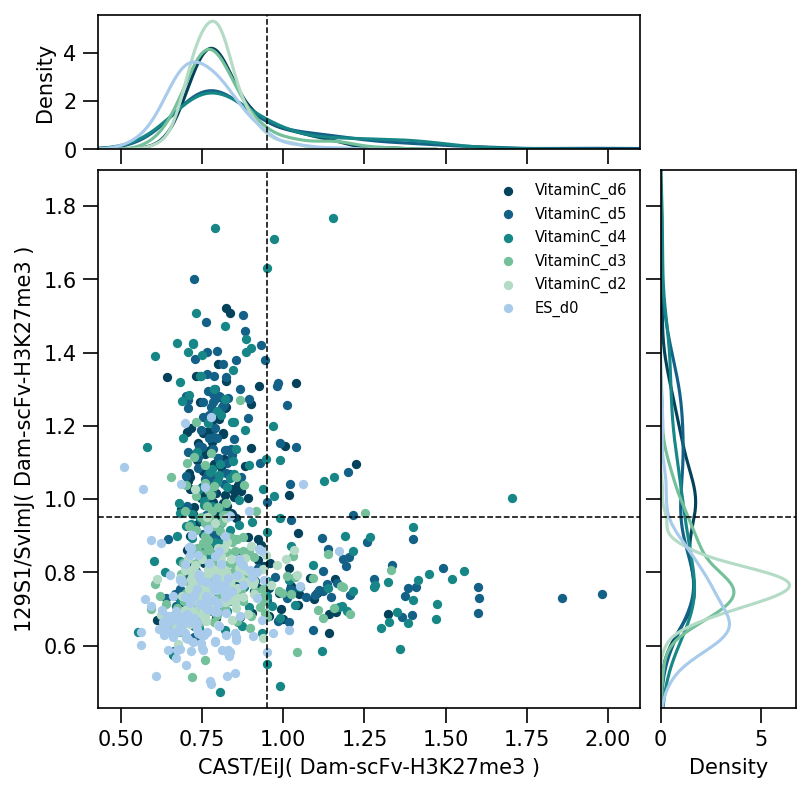

In [206]:
f, ax = plt.subplots(2, 2, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.2],
                                                       'hspace':.06,
                                                       'wspace':.06})

for i,g in enumerate(list(bc_dict)[::-1]):
    X = np.mean([fftconvolve(oe_dam_cas[bc][chrom], W, mode='same')[incl_idx] for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_dam_129[bc][chrom], W, mode='same')[incl_idx] for bc in bc_dict[g]], axis=1)
    
    sns.scatterplot(x=X, 
                    y=y, 
                    color=coldict[g[-1]],
                    s=20,
                    linewidth=0, 
                    label=g[-1], 
                    ax=ax[1,0]
    )
    
    sns.kdeplot(x=X, 
                color=coldict[g[-1]], 
                ax=ax[0,0]
    )
    
    sns.kdeplot(y=y, 
                color=coldict[g[-1]], 
                common_norm=False,
                ax=ax[1,1]
    )
    

ax[1,0].set_xlim(.43,2.1)
ax[1,0].set_ylim(.43,1.9)
ax[0,1].remove()
ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])

ax[1,0].legend(prop={'size':7}, frameon=False)

ax[1,0].set_xlabel('CAST/EiJ( Dam-scFv-H3K27me3 )')
ax[1,0].set_ylabel('129S1/SvImJ( Dam-scFv-H3K27me3 )')

for i in range(ax.shape[0]):
    ax[i,0].axvline(thrs, color='k', lw=.75, ls='--')
    ax[1,i].axhline(thrs, color='k', lw=.75, ls='--')

____

In [207]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [208]:
bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_dam_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_dam_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((921,), array([528,  28, 129, 236]))

In [209]:
#make sure ``bcs`` has same order as ``anno_sub.index``
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

___

/var/folders/d3/ds8510h555lcqcfl049qyr_40000gn/T/ipykernel_15531/3138908124.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(states.values(), rotation=45, ha='right')


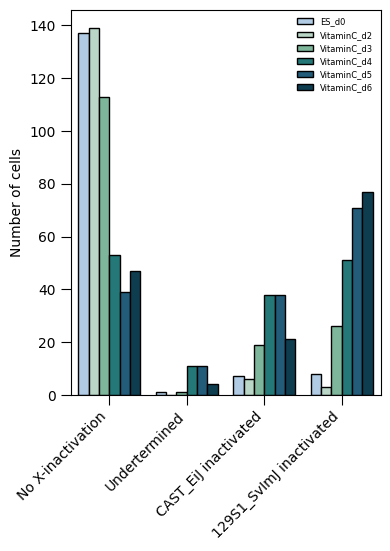

In [210]:
labels = np.repeat([g[-1] for g in bc_dict], 4).reshape(len(bc_dict),4)

X = np.zeros((len(bc_dict),4))
for i,g in enumerate(bc_dict):
    idx = np.isin(bcs, bc_dict[g])
    X[i] = state[idx].sum(0)
    
f, ax = plt.subplots(figsize=(4,5), dpi=100)

sns.barplot(x=np.hstack(np.tile(list(states.values()), 6)), 
            y=np.hstack(X), 
            hue=np.hstack(labels), 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
            edgecolor='k',
)

ax.set_ylabel('Number of cells')
ax.set_xticklabels(states.values(), rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1,1), prop={'size':6}, frameon=False)

___

In [211]:
smooth_stddev = 350000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

In [212]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], w, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], w, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], w, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], w, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((921, 2, 1711), (921, 2, 1711))

Text(0.5, 0, 'Chromosome X (Mb)')

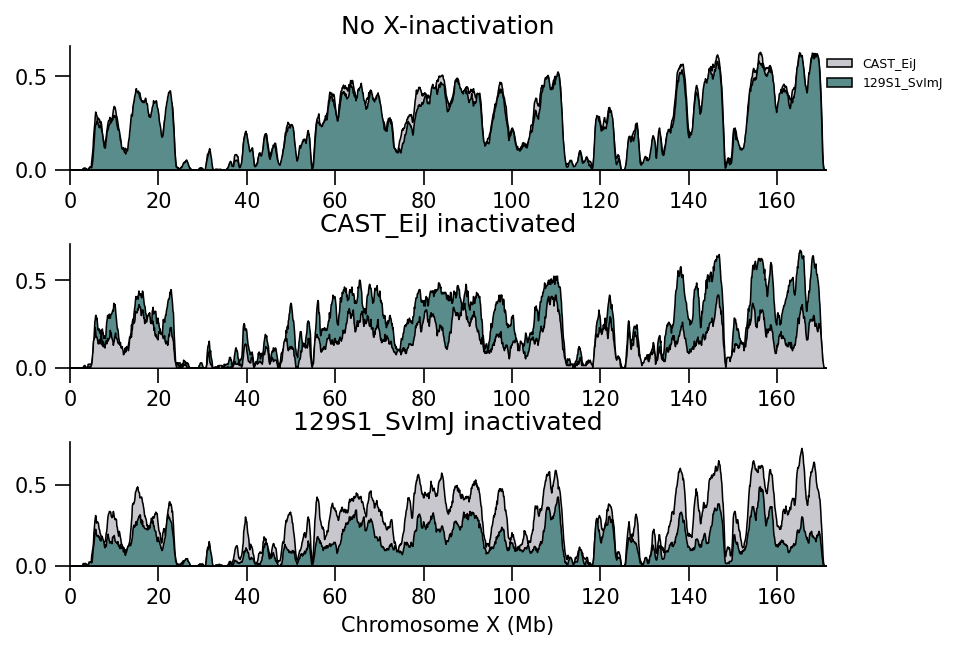

In [216]:
xaxis = np.arange(0,incl_idx.size*BINSIZE,BINSIZE) / 1e6

f, ax = plt.subplots(3, 1, figsize=(6.5,1.5*3), gridspec_kw={'hspace':.6})

for i,s in enumerate((0,2,3)):
    ax[i].fill_between(xaxis, 
                       (chic3d[state[:,s],0] > 1).mean(0), 
                       color='#C7C7CD', 
                       lw=.75,
                       zorder=[0,10,0][i],
                       edgecolor='k', 
                       label='CAST_EiJ'
    )
    ax[i].fill_between(xaxis, 
                       (chic3d[state[:,s],1] > 1).mean(0), 
                       color='#5A8C8C',
                       lw=.75,
                       edgecolor='k',
                       label='129S1_SvImJ'
    )
    
    ax[i].set_title(states[s])
    ax[i].set_ylim(0)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].margins(x=0)
    
ax[0].legend(bbox_to_anchor=(1.17,1), prop={'size':6}, frameon=False)
ax[-1].set_xlabel('Chromosome %s (Mb)' %chrom)